In [1]:
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
#import pickle
#from scipy.spatial import cKDTree
#from SCTransform import SCTransform


#from nico import Annotations as sann
import Annotations as sann


import warnings
import time
warnings.filterwarnings('ignore')
#export PYTHONWARNINGS='ignore:Multiprocessing-backed parallel loops:UserWarning'
os.environ["PYTHONWARNINGS"] = "ignore::UserWarning"



In [2]:
# This function find the common gene index between two data.  
def find_index(sp_genename,sc_genename):
    index_sc=[]
    index_sp=[]
    d={}
    for j in range(len(sc_genename)):
        name=sc_genename[j]
        d[name]=j

    for i in range(len(sp_genename)):
        name=sp_genename[i]
        try:
            d[name]
            flag=1
        except KeyError:
            flag=0
        if flag==1:
            index_sc.append(d[name])
            index_sp.append(i)
    return index_sp,index_sc


In [3]:
# This is input data path for the scRNA-seq and spatial data 
# If the data is not in h5ad or csv format then please adjust following the standard scanpy routine. 

scdatapath='./inputRef/'
spdatapath='./inputQuery/'

ad_spatial_ori=sc.read(spdatapath+'gene_by_cell.csv').transpose()
ad_seq_ori=sc.read_h5ad(scdatapath+'input_ref.h5ad') 

# This is the coordinate file of the cell centroids from the spatial transcriptomics experiment.  
coordinate = pd.read_csv(spdatapath+'tissue_positions_list.csv')
coordinate=coordinate.to_numpy()


In [4]:
# make sure that the order of cells in the count matrix and in the cell location 
#matrix are identical (command should return TRUE); otherwise correct the order

np.array_equal(coordinate[:,0],ad_spatial_ori.obs_names)

True

In [5]:
ad_spatial_ori.obsm['spatial']=coordinate[:,1:].astype(float)

In [6]:
# data size of the variables 
print(ad_spatial_ori)
print(ad_seq_ori)
print(coordinate.shape)

AnnData object with n_obs × n_vars = 7416 × 241
    obsm: 'spatial'
AnnData object with n_obs × n_vars = 2239 × 32287
    obs: 'cluster'
(7416, 4)


In [7]:
# Filter the cells and genes 
sc.pp.filter_cells(ad_spatial_ori, min_counts=5)
sc.pp.filter_cells(ad_seq_ori, min_counts=5)

sc.pp.filter_genes(ad_spatial_ori, min_cells=1)
sc.pp.filter_genes(ad_seq_ori, min_cells=1)

print(ad_spatial_ori)
print(ad_seq_ori)

AnnData object with n_obs × n_vars = 7416 × 241
    obs: 'n_counts'
    var: 'n_cells'
    obsm: 'spatial'
AnnData object with n_obs × n_vars = 2239 × 21197
    obs: 'cluster', 'n_counts'
    var: 'n_cells'


In [8]:
Original_counts=ad_seq_ori.copy()
Original_counts.raw=Original_counts.copy()

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


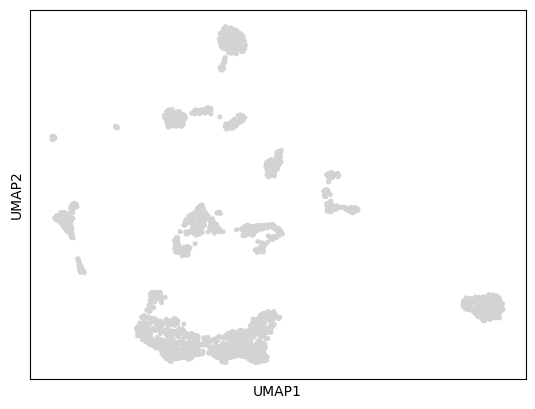

In [9]:
# Standard scanpy analysis 

sc.pp.normalize_total(Original_counts)
sc.pp.log1p(Original_counts)

sc.tl.pca(Original_counts)
sc.pp.neighbors(Original_counts)
sc.tl.umap(Original_counts)
sc.pl.umap(Original_counts)


In [10]:
# save the data 
Original_counts.write_h5ad(scdatapath+'Original_counts.h5ad')

In [11]:
sp_genename=ad_spatial_ori.var_names.to_numpy()
sc_genename=ad_seq_ori.var_names.to_numpy()

index_sp,index_sc=find_index(sp_genename,sc_genename)
ad_seq_common=ad_seq_ori[:,index_sc].copy()
ad_spatial_common=ad_spatial_ori[:,index_sp].copy()

print(len(sp_genename[index_sp]))
print(len(sc_genename[index_sc]))

203
203


In [12]:
# save the data in the respective directories 
ad_seq_common.write_h5ad(scdatapath+'common_counts_sc.h5ad')
ad_spatial_common.write_h5ad(spdatapath+'common_counts_sp.h5ad')

In [13]:
# perform scTranform normalization common gene space for spatial data and scRNAseq data  
sc.experimental.pp.normalize_pearson_residuals(ad_seq_common,inplace=True)
ad_seq_common.write_h5ad(scdatapath+'sct_singleCell.h5ad')

In [14]:
sc.experimental.pp.normalize_pearson_residuals(ad_spatial_common,inplace=True)


# Perform Leiden clustering on spatial transcriptomics data to guide the NiCo annotations 

In [15]:
# standard scanpy analysis 
sc.pp.pca(ad_spatial_common)
sc.pp.neighbors(ad_spatial_common,n_pcs=30)
sc.tl.umap(ad_spatial_common)

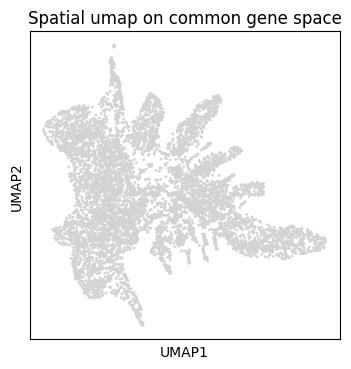

In [16]:
# visualize umap 
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(ad_spatial_common, title=["Spatial umap on common gene space"],wspace=0.4,show=True)

In [17]:
sc.tl.leiden(ad_spatial_common, resolution=0.3,key_added="leiden0.3")
sc.tl.leiden(ad_spatial_common, resolution=0.4,key_added="leiden0.4")
sc.tl.leiden(ad_spatial_common, resolution=0.5,key_added="leiden0.5")
#sc.tl.leiden(sct_ad_sp, resolution=0.6,key_added="leiden0.6")
#sc.tl.leiden(sct_ad_sp, resolution=0.7,key_added="leiden0.7")
#sc.tl.leiden(sct_ad_sp, resolution=0.8,key_added="leiden0.8")

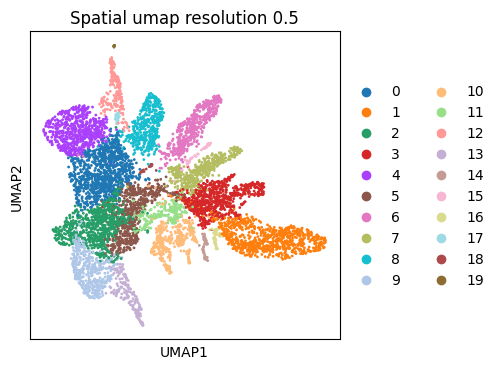

In [18]:
# Visualize your initial spatial clustering in the umap 
# A good resolution parameter should yield clusters corresponding to major cell types.  

sc.pl.umap(ad_spatial_common, color=["leiden0.5"], title=["Spatial umap resolution 0.5"],wspace=0.4,
           show=True, save='_spatial_leiden_louvain.png')

In [19]:
# Save the Leiden clusters for all resolution parameters as well as normalized count data in h5ad format.  
ad_spatial_common.write_h5ad(spdatapath+'sct_spatial.h5ad')